In [2]:
import os
import faiss
import torch
from matplotlib import pyplot as plt
from PIL import Image
from transformers import (
    AutoTokenizer  ,
    AutoModelForSeq2SeqLM , AutoTokenizer, AutoModelForSeq2SeqLM , Blip2Processor, Blip2ForConditionalGeneration
)
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl",
    device_map="auto",
    torch_dtype=torch.float16
)
generator_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
generator = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1614: UserWarning: The following device_map keys do not match any submodules in the model: ['query_tokens', 'language_model.decoder.embed_tokens']
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [101]:
from google.colab import drive
drive.mount('/content/drive')
knowledge_img_dir = "/content/Images"
query_image_path = "/content/Images/car11.jpg"

import os
print(os.listdir(knowledge_img_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['71.jpg', '38.jpg', '17.jpg', '27.jpg', '22.jpg', '52.jpg', '43.jpg', '51.jpg', '69.jpg', '30.jpg', 'car6.jpg', '8.jpg', '36.jpg', '68.jpg', '9.jpg', '58.jpg', 'car2.jpg', 'plate.jpg', '39.jpg', 'car.jpg', 'car1.jpg', '41.jpg', '24.jpg', '48.jpg', '73.jpg', '80.jpg', '44.jpg', '76.jpg', '34.jpg', '42.jpg', '47.jpg', 'car9.jpg', '37.jpg', '49.jpg', '13.jpg', 'car11.jpg', '14.jpg', '20.jpg', '75.jpg', '55.jpg', '29.jpg', '62.jpg', '57.jpg', '54.jpg', '79.jpg', '6.jpg', '31.jpg', '5.jpg', '63.jpg', '64.jpg', '16.jpg', 'car5.jpg', '53.jpg', '32.jpg', '74.jpg', '1.jpg', '26.jpg', '59.jpg', '23.jpg', 'car10.jpg', '2.jpg', 'car4.jpg', '33.jpg', '4.jpg', 'car3.jpg', 'car7.jpg', '70.jpg', '19.jpg', '78.jpg', '25.jpg', '77.jpg', '18.jpg', '10.jpg', '3.jpg', '7.jpg', '21.jpg', '40.jpg', 'car8.jpg', '50.jpg', '56.jpg', '46.jpg', '15.jpg', '61.jpg']


In [102]:

knowledge_captions = []
image_paths = []

for filename in tqdm(os.listdir(knowledge_img_dir)):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(knowledge_img_dir, filename)
        image = Image.open(img_path).convert("RGB")

        inputs = blip2_processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        out = blip2_model.generate(**inputs)
        caption = blip2_processor.decode(out[0], skip_special_tokens=True)

        knowledge_captions.append(caption)
        image_paths.append(img_path)

print("\n*** Knowledge Captions ***\n")
for cap in knowledge_captions:
    print(cap)


100%|██████████| 83/83 [08:30<00:00,  6.16s/it]


*** Knowledge Captions ***

a car with a dent in the front bumper
a car with a broken bumper
a car with a broken windshield
a green car with a broken windshield
a car accident can cause serious injuries
a car accident in a city street
a car with a broken windshield and a broken windshield
a small silver car parked on the side of a street
a porsche boxster parked in a parking lot
a red car with a broken windshield and a broken windshield
samsung s3 s3 s3 s3 s3
a silver car with a dent in the front end
a vw golf gti parked in a parking lot
a car with a black door handle and a black door handle
a car crash in a road accident
chevy blazer vw e-tron e-tron e-
a car crashed into a truck in a slum area in chenna
a plate with a broken plate and a broken plate with a knife and fork
a red nissan nissan nissan n
a black chevy sl chevy sl chevy s
a car crashes into a truck on a highway in a city
a white car with a white hood and a white hood
a car is parked on the side of a street
bmw e46 e46 e46

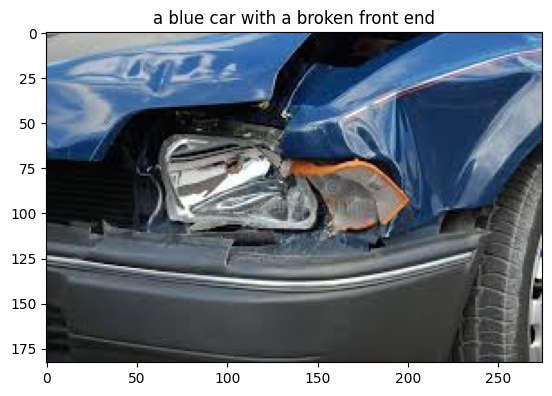

In [106]:
# Create FAISS index ---
retriever = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = retriever.encode(knowledge_captions)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings.astype('float32'))

# Process the query image ---
query_image = Image.open(query_image_path).convert("RGB")
inputs = blip2_processor(images=query_image,return_tensors="pt").to(device)
out = blip2_model.generate(**inputs)
basic_caption = blip2_processor.decode(out[0], skip_special_tokens=True)

plt.title(basic_caption)
plt.imshow(query_image)

In [107]:
#RAG Enhancement
retriever = SentenceTransformer("all-MiniLM-L6-v2")
query_embedding = retriever.encode([basic_caption])
scores, indices = index.search(query_embedding.astype('float32'), 3)

relevant_knowledge = []
for i, score in zip(indices[0], scores[0]):
    if score > 0.4:
        relevant_knowledge.append(knowledge_captions[i])

relevant_knowledge

['a blue car with a broken front end',
 'a car with a broken rear bumper',
 'a car with a broken windshield']

In [108]:
user_question = "Explain the image"

# Prepare the context for FLAN
if relevant_knowledge:
    context = "\n".join(relevant_knowledge)
else:
    context = ""

# Build a focused prompt
prompt = (
    f"Image caption: {basic_caption}\n"
    f"Related knowledge: {context}\n"
    f"Question: {user_question}\n"
    f"Answer:"
)

# Tokenize and generate
inputs = generator_tokenizer(prompt, return_tensors="pt").to(device)
output = generator.generate(**inputs, max_new_tokens=50)
answer = generator_tokenizer.decode(output[0], skip_special_tokens=True)

print(answer)

A blue car with a broken front end is seen in a parking lot.
